In [1]:
%pip install pandas
%pip install matplotlib
%pip install wget
%pip install numpy

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import wget

# Download the files using Python's wget
wget.download("https://raw.githubusercontent.com/MicrosoftDocs/mslearn-introduction-to-machine-learning/main/m0b_optimizer.py")
wget.download("https://raw.githubusercontent.com/MicrosoftDocs/mslearn-introduction-to-machine-learning/main/Data/seattleWeather_1948-2017.csv")

# Load the CSV
data = pd.read_csv("seattleWeather_1948-2017.csv", parse_dates=["date"])

# Keep only January data
data = data[[d.month == 1 for d in data.date]].copy()

# Display the data
data


,date,amount_of_precipitation,max_temperature,min_temperature,rain
0,1948-01-01,0.47,51,42,True
1,1948-01-02,0.59,45,36,True
2,1948-01-03,0.42,45,35,True
3,1948-01-04,0.31,45,34,True
4,1948-01-05,0.17,45,32,True
...,...,...,...,...,...
25229,2017-01-27,0.00,54,37,False
25230,2017-01-28,0.00,52,37,False
25231,2017-01-29,0.03,48,37,True
25232,2017-01-30,0.02,45,40,True


Data locally downloaded and then parsed through with dates being considered as datetime format which would've ususally been string
then in a new memory block the data containing only the first month is placed

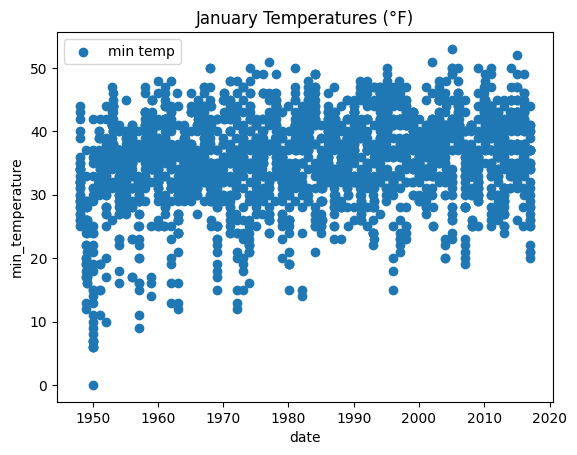

In [3]:
import matplotlib.pyplot as plt
# Let's take a quick look at our data
plt.scatter(data["date"], data["min_temperature"], label='min temp')
# add labels and legend
plt.xlabel("date")
plt.ylabel("min_temperature")
plt.title("January Temperatures (°F)")
plt.legend()

C:\Users\hp\AppData\Local\Temp\ipykernel_20788\2720988930.py:14: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


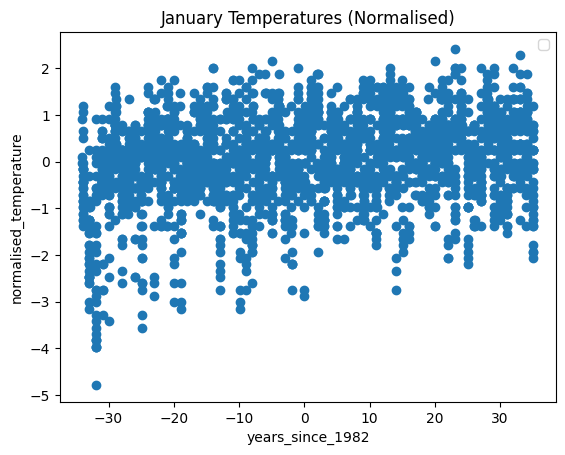

In [4]:
import numpy as np
# This block of code scales and offsets the data slightly, which helps the training process
# You don't need to understand this code. We'll cover these concepts in later learning material
# Offset date into number of years since 1982
data["years_since_1982"] = [(d.year + d.timetuple().tm_yday / 365.25) - 1982 for d in data.date]
# Scale and offset temperature so that it has a smaller range of values
data["normalised_temperature"] = (data["min_temperature"] - np.mean(data["min_temperature"])) / np.std(data["min_temperature"])
# Graph
plt.scatter(data["years_since_1982"], data["normalised_temperature"])
# add labels and legend
plt.xlabel("years_since_1982")
plt.ylabel("normalised_temperature")
plt.title("January Temperatures (Normalised)")
plt.legend()

Date is fractioned to get its values in fraction of years since 1982
$$
z = \frac{x - \mu}{\sigma}
$$
Z-Score Normalization, make the mean 0 and standard deviation 1, this scales the data and makes their values their deviation from the mean, standardising the data

In [5]:
class MyModel:

  def __init__(self):
      '''
      Creates a new MyModel
      '''
      # Straight lines described by two parameters:
      # The slope is the angle of the line
      self.slope = 0
      # The intercept moves the line up or down
      self.intercept = 0

  def predict(self, date):
      '''
      Estimates the temperature from the date
      '''
      return date * self.slope + self.intercept

# Create our model ready to be trained
model = MyModel()

print("Model made!")

Model made!


Basic 2 parameter linear model, mimics the slope-intercept formula
$$
y = m*x +c
$$
For now, slope(m) and intercept(c) are 0. Returning a flat line

Model parameters before training: 0, 0
Model visualised before training:


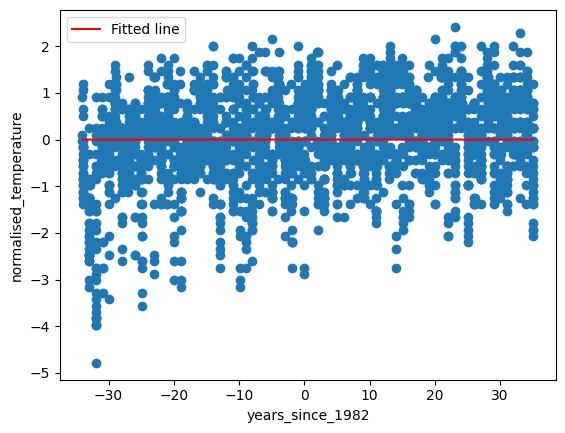

In [6]:
print(f"Model parameters before training: {model.intercept}, {model.slope}")
 
# Look at how well the model does before training
print("Model visualised before training:")
 
plt.scatter(data["years_since_1982"], data["normalised_temperature"])
plt.plot(data["years_since_1982"], model.predict(data["years_since_1982"]), 'r', label='Fitted line')
 
                                                 
# add labels and legend
plt.xlabel("years_since_1982")
plt.ylabel("normalised_temperature")
plt.legend()

In [7]:
def cost_function(actual_temperatures, estimated_temperatures):
    '''
    Calculates the difference between actual and estimated temperatures
    Returns the difference, and also returns the squared difference (the cost)
 
    actual_temperatures: One or more temperatures recorded in the past
    estimated_temperatures: Corresponding temperature(s) estimated by the model
    '''
 
    # Calculate the difference between actual temperatures and those
    # estimated by the model
    difference = estimated_temperatures - actual_temperatures
 
    # Convert to a single number that tells us how well the model did
    # (smaller numbers are better)
    cost = sum(difference ** 2)
 
    return difference, cost

Cost Function utilizing the Sum of Squared Differences technique.

In [8]:
from m0b_optimizer import MyOptimizer
 
# Create an optimizer
optimizer = MyOptimizer()

Optimizer uses SSD method to calc Gradient. Its is just a list of vectors that measure the rate of change of cost function wrt to some parameter. Here we're using slope and intercept. The formula is the differentiation of the SSD formula with respect to m and c.
$$
\text{gradSlope} = 2 \cdot \sum ( \text{diff} \cdot \text{modelInput} )
$$

$$
\text{gradIntercept} = 2 \cdot \sum (\text{diff})
$$
Using the Gradient Descent Technique, we try to reduce the Gradient as much as possible, the best is if its 0. For this we now keep updating the slope and the intercept, but we are doing it very slowly taking small steps descenting down the gradient, with a -ve sign cus if grad -ve then we move forward, if it +ve then we move back.

In [9]:
def train_one_iteration(model_inputs, true_temperatures, last_cost:float):
    '''
    Runs a single iteration of training.
 
 
    model_inputs: One or more dates to provide the model (dates)
    true_temperatues: Corresponding temperatures known to occur on those dates
 
    Returns:
        A Boolean, as to whether training should continue
        The cost calculated (small numbers are better)
    '''
 
    # === USE THE MODEL ===
    # Estimate temperatures for all data that we have
    estimated_temperatures = model.predict(model_inputs)
 
    # === OBJECTIVE FUNCTION ===
    # Calculate how well the model is working
    # Smaller numbers are better 
    difference, cost = cost_function(true_temperatures, estimated_temperatures)
 
    # Decide whether to keep training
    # We'll stop if the training is no longer improving the model effectively
    if cost >= last_cost:
        # Stop training
        return False, cost
    else:
        # === OPTIMIZER ===
        # Calculate updates to parameters
        intercept_update, slope_update = optimizer.get_parameter_updates(model_inputs, cost, difference)
 
        # Change the model parameters
        model.slope += slope_update
        model.intercept += intercept_update
 
        return True, cost
 
print("Training method ready")

Training method ready


In [10]:
import math
 
print(f"Model parameters before training:\t\t{model.intercept:.8f},\t{model.slope:.8f}")
 
continue_loop, cost = train_one_iteration(model_inputs = data["years_since_1982"], true_temperatures = data["normalised_temperature"], last_cost = math.inf)
 
print(f"Model parameters after 1 iteration of training:\t{model.intercept:.8f},\t{model.slope:.8f}")

Model parameters before training:		0.00000000,	0.00000000
Model parameters after 1 iteration of training:	0.00000000,	0.01006832


Training beginning...
Iteration: 0
Iteration: 400
Iteration: 800
Iteration: 1200
Iteration: 1600
Iteration: 2000
Iteration: 2400
Iteration: 2800
Iteration: 3200
Iteration: 3600
Iteration: 4000
Iteration: 4400
Iteration: 4800
Training complete!
Model parameters after training:	-0.00648923,	0.01193327


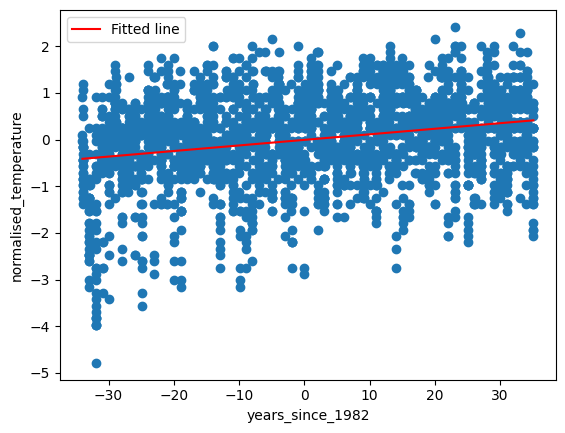

In [11]:
# Start the loop
print("Training beginning...")
last_cost = math.inf
i = 0
continue_loop = True
while continue_loop:
 
    # Run one iteration of training
    # This will tell us whether to stop training, and also what
    # the cost was for this iteration
    continue_loop, last_cost = train_one_iteration(model_inputs = data["years_since_1982"],
                                                    true_temperatures = data["normalised_temperature"],
                                                    last_cost = last_cost)
   
    # Print the status
    if i % 400 == 0:
        print("Iteration:", i)
 
    i += 1
 
    
print("Training complete!")
print(f"Model parameters after training:\t{model.intercept:.8f},\t{model.slope:.8f}")
 
plt.scatter(data["years_since_1982"], data["normalised_temperature"])
plt.plot(data["years_since_1982"], model.predict(data["years_since_1982"]), 'r', label='Fitted line')
                              
# add labels and legend
plt.xlabel("years_since_1982")
plt.ylabel("normalised_temperature")
plt.legend()